# CRISP-DM

## 1. Entendimento do Negócio

**Objetivo**: 
Precisamos resolver um problema de transações fraudulentas. Atualmente, todas as transações feitas são consideradas como legítmas, logo, a empresa está perdendo uma quantidade considerável de dinheiro. Precisamos construir um modelo escalável, barato e robusto para identificar as transações fraudulentas.

Atualmente, como não há um modelo de fraude e todas as fraudes estão sendo consideradas legítmas, o baseline inicial será baseado nesses valores:

$\text{total_arrecadado}$ = $\text{total}$ - $\text{total_fraud}$

sendo: 
- $\text{total}$ = soma de todos os valores das transações no periodo avaliado
- $\text{total_fraud}$ = soma de todos os valores das transações consideradas fraude no periodo avaliado

## 2. Entendimento dos Dados

**Objetivo**: Nosso conjunto de dados foi obtido a partir do livro: 
- https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_3_GettingStarted/SimulatedDataset.html

Nosso conjunto de dados é composto por duas tabelas:
1. transactions
    - **transaction_id**: Identificador único das transações;

    - **tx_datetime**: Date e hora que a transação ocorreu;

    - **customer_id**: Identificador único do cliente. Cada cliente tem um identificador único;

    - **tx_amount**: Valor da transação;

    - **tx_time_seconds**: Datetime em segundos
    
    - **tx_fraud**: Variável binária, com o valor 0 para transações legitmas e 1 para transações fraudulentas.


2. Customer
    - **customer_id**: The customer unique ID

    - **(x_customer_id,y_customer_id)**: Par de coordenadas reais em uma grade 100*100 que define a localização geográfica do cliente.
    
    - **mean_amount / std_amount**: A média e o desvio padrão dos valores de transação dos clientes.

## 3. Preparação dos Dados

**Objetivo**: Criar features robustas e eliminar informações desnecessárias.
    
- Ciclo 01:
    - Manter as variáveis originais

## 4. Modelagem

**Objetivo**: Construir modelos preditivos e avaliar performance.
    
- Ciclo 01:
    - Criar Random Forest com todas as features para obter um novo baseline.
    - Calcular AUC-ROC, Recall, Precision, F1-Score.
    - Analisar Feature Importance para identificar possíveis redundâncias.

## 5. Avaliação

**Objetivo**: Verificar se o modelo atende às necessidades de detecção de fraudes.

- Construir um novo $\text{total_arrecadado}$ baseado na matriz de confusão.

- Métricas principais: 
    - Matriz de Confusão
    - AUC-ROC, 
    - Recall, 
    - Precision, 
    - F1-Score

## 6. Deploy (Produção)

Em breve, nos próximos ciclos será definido.

# Projeto

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# Read Csv Files

In [2]:
main_dir = '../'

transactions_df = pd.read_csv(f'{main_dir}data/csv_raw_files/transactions.csv')
customer_profiles_table = pd.read_csv(f'{main_dir}data/csv_raw_files/customer_profiles_table.csv')

# Checando Tipos

In [3]:
transactions_df.dtypes

TRANSACTION_ID       int64
TX_DATETIME         object
CUSTOMER_ID          int64
TX_AMOUNT          float64
TX_TIME_SECONDS      int64
TX_FRAUD             int64
dtype: object

In [4]:
customer_profiles_table.dtypes

CUSTOMER_ID        int64
x_customer_id    float64
y_customer_id    float64
mean_amount      float64
std_amount       float64
dtype: object

# Checando NA

In [5]:
transactions_df.isna().sum()

TRANSACTION_ID     0
TX_DATETIME        0
CUSTOMER_ID        0
TX_AMOUNT          0
TX_TIME_SECONDS    0
TX_FRAUD           0
dtype: int64

In [6]:
customer_profiles_table.isna().sum()

CUSTOMER_ID      0
x_customer_id    0
y_customer_id    0
mean_amount      0
std_amount       0
dtype: int64

# Limpando dados

In [7]:
transactions_df.sample(5)

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_FRAUD
38853,38853,2018-04-05 03:31:00,1352,143.30,358260,0
215212,215212,2018-04-23 11:01:15,4998,55.48,1940475,0
1504100,1504100,2018-09-04 20:07:49,1664,72.70,13550869,0
329394,329394,2018-05-05 09:22:03,4617,85.07,2971323,0
1176255,1176255,2018-08-01 14:30:09,3974,41.00,10593009,0


In [8]:
customer_profiles_table.sample(5)

,CUSTOMER_ID,x_customer_id,y_customer_id,mean_amount,std_amount
4227,4227,72.415269,98.744748,77.554572,38.777286
1905,1905,91.369997,61.344273,64.583173,32.291586
4972,4972,83.703919,19.934996,10.511588,5.255794
3679,3679,95.400730,33.768353,62.432792,31.216396
4527,4527,10.580474,41.470797,38.194264,19.097132


Removido as colunas de media e std para evitar dataleakage

In [9]:
customer_profiles_table = customer_profiles_table[['CUSTOMER_ID', 'x_customer_id', 'y_customer_id']]

In [10]:
customer_profiles_table.to_parquet('../data/customer_profiles_table.parquet')

In [11]:
transactions_df.columns = transactions_df.columns.str.lower()
customer_profiles_table.columns = customer_profiles_table.columns.str.lower()

In [12]:
transactions_df['tx_datetime'] = pd.to_datetime(transactions_df['tx_datetime']) 

# Separação em Treino e Teste

In [13]:
transactions_df = transactions_df.sort_values(by="tx_datetime")

split_date = transactions_df["tx_datetime"].quantile(0.8)

train_df = transactions_df[transactions_df["tx_datetime"] < split_date]
test_df = transactions_df[transactions_df["tx_datetime"] >= split_date]

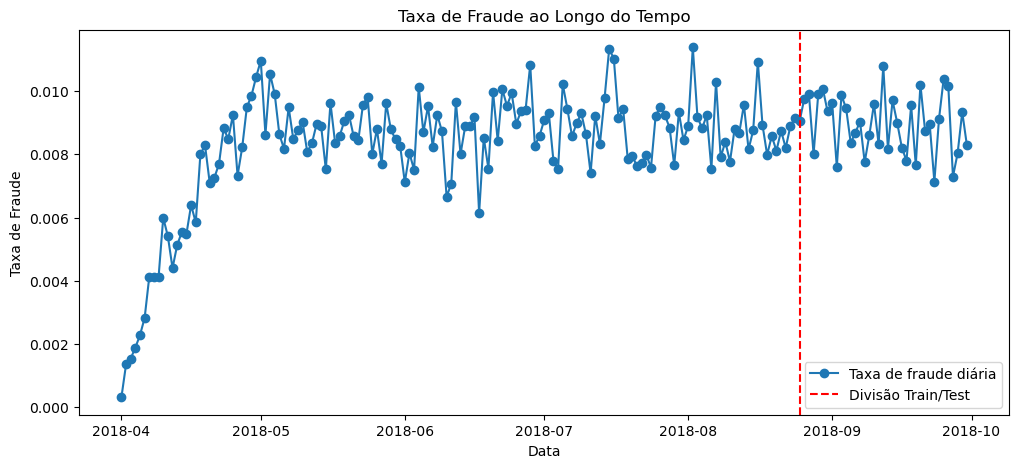

In [14]:
transactions_df["tx_date"] = transactions_df["tx_datetime"].dt.date
fraude_por_dia = transactions_df.groupby("tx_date")["tx_fraud"].mean()


plt.figure(figsize=(12, 5))
plt.plot(fraude_por_dia, marker="o", linestyle="-", label="Taxa de fraude diária")
plt.axvline(split_date.date(), color="red", linestyle="--", label="Divisão Train/Test")
plt.xlabel("Data")
plt.ylabel("Taxa de Fraude")
plt.title("Taxa de Fraude ao Longo do Tempo")
plt.legend()
plt.show()


A divisão em 80% faz sentido, a variação de fraudes diárias não muda muito do padrão visto anteriormente.

In [15]:
train_df.to_parquet("../data/train_df.parquet", index=False)
test_df.to_parquet("../data/test_df.parquet", index=False)

In [16]:
train_df.dtypes

transaction_id              int64
tx_datetime        datetime64[ns]
customer_id                 int64
tx_amount                 float64
tx_time_seconds             int64
tx_fraud                    int64
dtype: object

# EDA

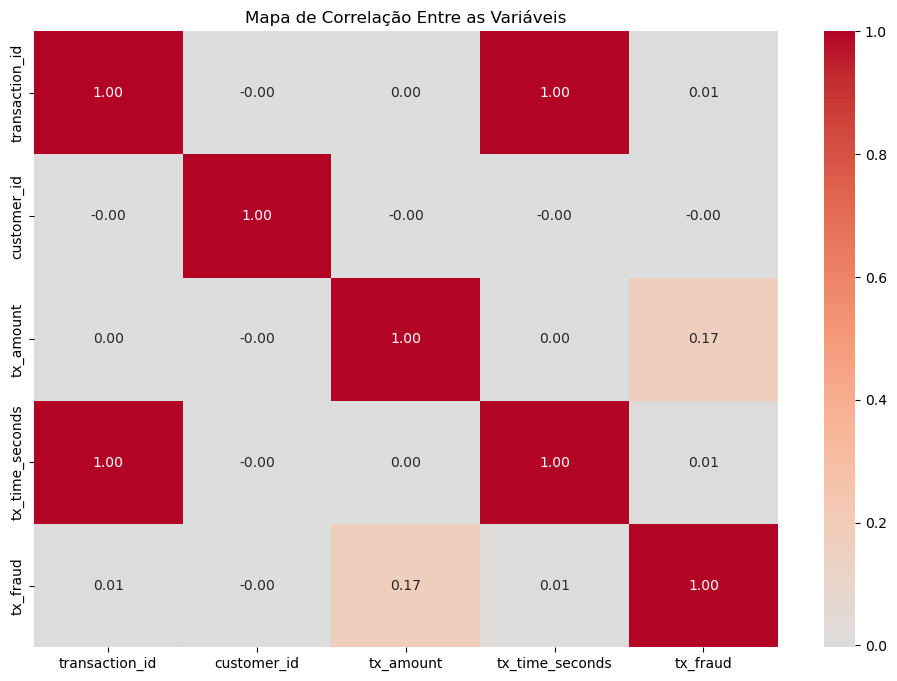

In [17]:
num_attributes = train_df.select_dtypes(include = ['int64', 'float64'])

plt.figure(figsize=(12, 8))
corr_matrix = num_attributes.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Mapa de Correlação Entre as Variáveis")
plt.show()

Como droparemos os ids, a alta correlação de tx_time_seconds acabará.

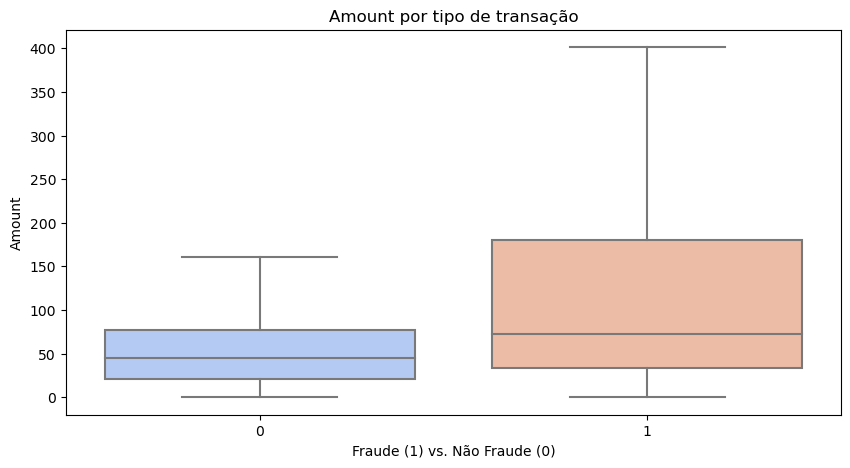

In [18]:
# Analisar tempo entre transações normais vs fraudes
plt.figure(figsize=(10, 5))
sns.boxplot(data=train_df, x="tx_fraud", y="tx_amount", showfliers=False, palette="coolwarm")
plt.title("Amount por tipo de transação")
plt.xlabel("Fraude (1) vs. Não Fraude (0)")
plt.ylabel("Amount")
plt.show()

In [19]:
train_df.groupby("tx_fraud")[["tx_amount"]].mean()

,tx_amount
tx_fraud,
0,52.986005
1,131.298758


O boxplot e a média das transações indica que transações maiores tem chance de serem fraudulentas

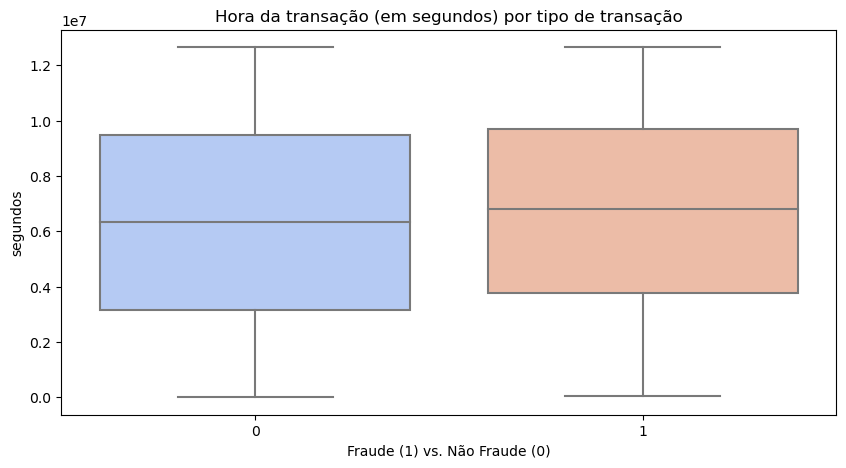

In [20]:
# Analisar tempo entre transações normais vs fraudes
plt.figure(figsize=(10, 5))
sns.boxplot(data=train_df, x="tx_fraud", y="tx_time_seconds", showfliers=False, palette="coolwarm")
plt.title("Hora da transação (em segundos) por tipo de transação")
plt.xlabel("Fraude (1) vs. Não Fraude (0)")
plt.ylabel("segundos")
plt.show()

Não deu pra ver diferenças.

# Treinando Modelo

In [21]:
features = [col for col in train_df.columns if col not in ["tx_fraud", "customer_id", 'transaction_id',"tx_datetime"]]
X_train, y_train = train_df[features], train_df["tx_fraud"]
X_test, y_test = test_df[features], test_df["tx_fraud"]

In [22]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

rf_model_50 = RandomForestClassifier(n_estimators=50, 
                                  max_depth=10,
                                  min_samples_split=10,
                                  min_samples_leaf=5,
                                  random_state=42, 
                                  class_weight='balanced',
                                  n_jobs=-1)
rf_model_50.fit(X_train, y_train)

rf_model_50_desbalanceada = RandomForestClassifier(n_estimators=50, 
                                  max_depth=10,
                                  min_samples_split=10,
                                  min_samples_leaf=5,
                                  random_state=42, 
                                  n_jobs=-1)
rf_model_50_desbalanceada.fit(X_train, y_train)

rf_model_100 = RandomForestClassifier(n_estimators=100,
                                  random_state=42,
                                  class_weight='balanced',
                                  n_jobs=-1)
rf_model_100.fit(X_train, y_train)

num_negativos = sum(y_train == 0) 
num_positivos = sum(y_train == 1)  
scale_pos_weight_value = num_negativos / num_positivos

xgb_model_100 = XGBClassifier(n_estimators=100, 
                              max_depth=6, 
                              learning_rate=0.1,
                              scale_pos_weight=4,
                              random_state=42)
xgb_model_100.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

# Avaliação

In [23]:
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score

def avaliar_modelo(model, X_train, y_train, X_test, y_test, threshold=0.5):
    """
    Avalia um modelo de Machine Learning comparando desempenho em treino e teste.

    Parâmetros:
    - model: modelo treinado (RandomForest, XGBoost, etc.)
    - X_train: features de treino
    - y_train: labels de treino
    - X_test: features de teste
    - y_test: labels de teste
    - threshold: valor limite para converter probabilidades em classes (default = 0.5)

    Retorna:
    - Dicionário com métricas de treino e teste
    - Imprime matriz de confusão e resultados
    """

    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    y_train_pred = (y_train_proba >= threshold).astype(int)
    y_test_pred = (y_test_proba >= threshold).astype(int)

    train_auc = roc_auc_score(y_train, y_train_proba)
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)

    test_auc = roc_auc_score(y_test, y_test_proba)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    metrics = {
        "AUC-ROC": {"Treino": train_auc, "Teste": test_auc},
        "Precision": {"Treino": train_precision, "Teste": test_precision},
        "Recall": {"Treino": train_recall, "Teste": test_recall},
        "F1-Score": {"Treino": train_f1, "Teste": test_f1},
    }

    # Exibir métricas formatadas
    print(f"\n{'Métrica':<15}{'Treino':<15}{'Teste'}")
    print(f"{'-'*40}")
    for key, value in metrics.items():
        print(f"{key:<15}{value['Treino']:.4f}         {value['Teste']:.4f}")

    print("\nMatriz de Confusão - Treino:")
    print(confusion_matrix(y_train, y_train_pred))

    print("\nMatriz de Confusão - Teste:")
    print(confusion_matrix(y_test, y_test_pred))

In [24]:
print("\n=== Avaliação do Random Forest n_estimators = 50 ===")
avaliar_modelo(rf_model_50, X_train, y_train, X_test, y_test)

print("\n=== Avaliação do Random Forest n_estimators = 50 (Desbalanceada) ===")
avaliar_modelo(rf_model_50_desbalanceada, X_train, y_train, X_test, y_test)

print("\n=== Avaliação do Random Forest n_estimators = 100 ===")
avaliar_modelo(rf_model_100, X_train, y_train, X_test, y_test)

print("\n=== Avaliação do XGBoost ===")
avaliar_modelo(xgb_model_100, X_train, y_train, X_test, y_test)


=== Avaliação do Random Forest n_estimators = 50 ===

Métrica        Treino         Teste
----------------------------------------
AUC-ROC        0.7270         0.6231
Precision      0.0712         0.6462
Recall         0.3232         0.2210
F1-Score       0.1166         0.3293

Matriz de Confusão - Treino:
[[1343138   48655]
 [   7804    3727]]

Matriz de Confusão - Teste:
[[347300    381]
 [  2454    696]]

=== Avaliação do Random Forest n_estimators = 50 (Desbalanceada) ===

Métrica        Treino         Teste
----------------------------------------
AUC-ROC        0.7200         0.6219
Precision      1.0000         1.0000
Recall         0.2248         0.2117
F1-Score       0.3671         0.3495

Matriz de Confusão - Treino:
[[1391793       0]
 [   8939    2592]]

Matriz de Confusão - Teste:
[[347681      0]
 [  2483    667]]

=== Avaliação do Random Forest n_estimators = 100 ===

Métrica        Treino         Teste
----------------------------------------
AUC-ROC        1.0000    

AUC-ROC: 0.6464
Precision: 0.5161
Recall: 0.2292
F1-Score: 0.3174


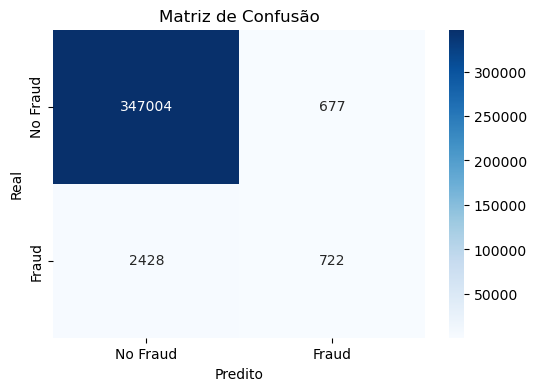

In [25]:
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


y_pred = xgb_model_100.predict(X_test)
y_pred_proba = xgb_model_100.predict_proba(X_test)[:, 1]

conf_matrix = confusion_matrix(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Métricas
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

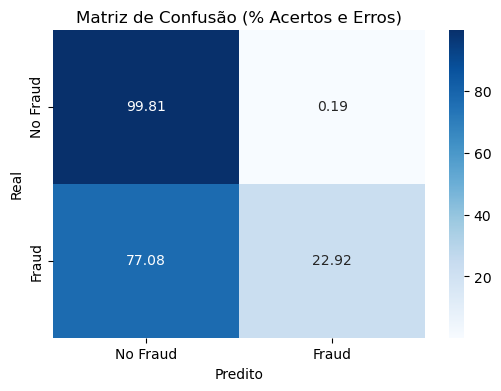

In [26]:
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão (% Acertos e Erros)")
plt.show()

In [27]:
results_df = X_test.copy()
results_df["Real"] = y_test.values
results_df["Predito"] = y_pred

conditions = [
    (results_df["Real"] == 0) & (results_df["Predito"] == 0),  # TN
    (results_df["Real"] == 0) & (results_df["Predito"] == 1),  # FP
    (results_df["Real"] == 1) & (results_df["Predito"] == 0),  # FN
    (results_df["Real"] == 1) & (results_df["Predito"] == 1)   # TP
]

choices = ["TN", "FP", "FN", "TP"]

results_df["Classificação"] = np.select(conditions, choices, default="Erro")

print(results_df.head())

         tx_amount  tx_time_seconds  Real  Predito Classificação
1403324      53.39         12652350     0        0            TN
1403325      47.31         12652362     0        0            TN
1403326      82.51         12652376     0        0            TN
1403327      22.23         12652377     0        0            TN
1403328      64.77         12652380     0        0            TN


In [28]:
total_amount = test_df['tx_amount'].sum()
total_amount_fraud = test_df[test_df['tx_fraud']==1]['tx_amount'].sum()

baseline = f"{(total_amount_fraud):.2f}"

tp_tx_amount = results_df[results_df["Classificação"] == "TP"]['tx_amount'].sum()
fn_tx_amount = results_df[results_df["Classificação"] == "FN"]['tx_amount'].sum()
fp_tx_amount = results_df[results_df["Classificação"] == "FP"]['tx_amount'].sum()
tn_tx_amount = results_df[results_df["Classificação"] == "TN"]['tx_amount'].sum()

total_ciclo = f"{(fn_tx_amount+fp_tx_amount):.2f}"

print(f""" Avaliação de Resultados (Quanto perdemos por causa de fraudes):
1. Baseline: R$ {baseline}
2. Modelo Ciclo 01: R$ {total_ciclo}
Variação percentual de {round((1 - (float(total_ciclo) / float(baseline))) * 100, 2)}% de redução nos custos
"""
     )

 Avaliação de Resultados (Quanto perdemos por causa de fraudes):
1. Baseline: R$ 411671.78
2. Modelo Ciclo 01: R$ 286230.30
Variação percentual de 30.47% de redução nos custos



## Importância das Variáveis

In [29]:
feature_importance = xgb_model_100.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

In [30]:
importance_df

,Feature,Importance
0,tx_amount,0.938777
1,tx_time_seconds,0.061223


Claramente estamos precisando de features novas! O modelo esta se baseando quase que 100% apenas no preço 

# Conclusão

Baseado no nosso modelo, conseguimos sair de um prejuízo de 411.671,78 para 286.230,30. O que representou uma redução de prejuízo de 69.53% com um modelo mais simples.

Porém, é importante salientar que podemos estar tendo um overfit em relação a importância das viaráveis. A única variável relevante está sendo o valor, logo, ela está simplificando que valores mais altos são fraudes e menores não. Talvez possamos melhorar isso com algumas novas features.

# Próximo Ciclo


1. Feature Engineering: Gerar novas variáveis
2. Testar exclusão de variáveis com baixa importância e rodar novo modelo.